<a href="https://colab.research.google.com/github/JurijJusel/Image/blob/t11-CNN-model/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [2]:
import time
from time import gmtime
from time import strftime

import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
# from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc

In [42]:
# connect to dataset in google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data


In [28]:
augmented_data_path = '/content/drive/MyDrive/Colab Notebooks/Image/data/augmented/train/'
validate_data_path = '/content/drive/MyDrive/Colab Notebooks/Image/data/augmented/validate/'

In [29]:
data = tf.keras.utils.image_dataset_from_directory(augmented_data_path)
validate_data = tf.keras.utils.image_dataset_from_directory(validate_data_path)

Found 3567 files belonging to 2 classes.
Found 603 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

In [ ]:
batch[0].shape

(32, 256, 256, 3)

In [ ]:
batch[1]

array([0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1], dtype=int32)

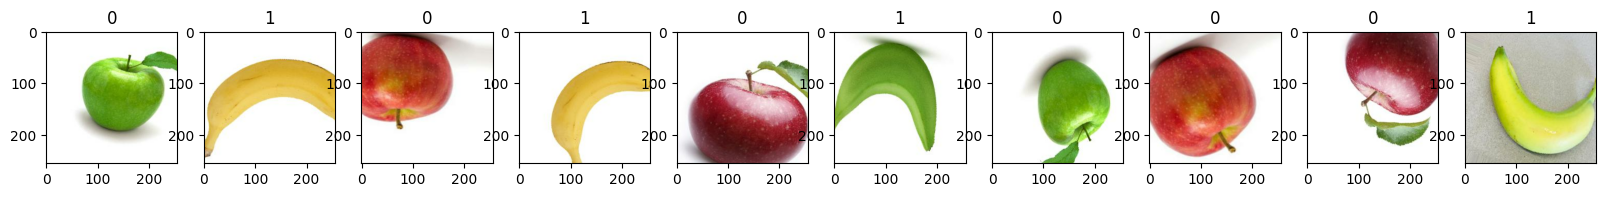

In [ ]:
fig, ax = plt.subplots(ncols=10, figsize=(20,20))
for idx, img in enumerate(batch[0][:10]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Data preprocessing

In [30]:
# Scale Data
data_scale = data.map(lambda x, y:(x/255, y))
validate_data_scale=validate_data.map(lambda x, y:(x/255, y))

In [16]:
scaled_iterator = data_scale.as_numpy_iterator()
batch = scaled_iterator.next()
batch[0].min()

0.0

In [ ]:
batch[0].max()

1.0

In [ ]:
batch[0].shape

(32, 256, 256, 3)

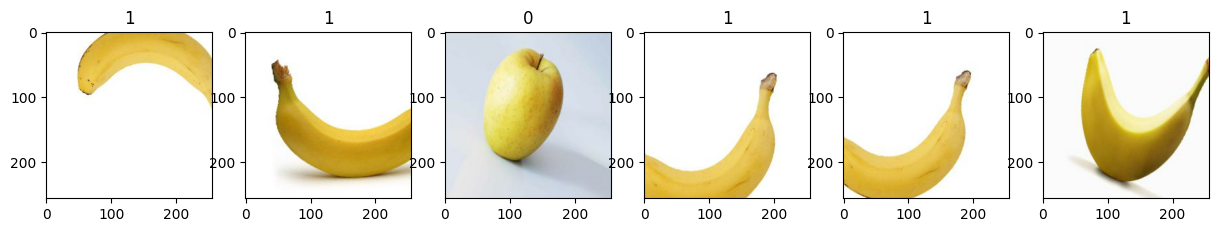

In [ ]:
fig, ax = plt.subplots(ncols=6, figsize=(15,15))
for idx, img in enumerate(batch[0][:6]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
len(data_scale )

112

In [ ]:
len(validate_data)

19

# Build Deep Learning model

In [31]:
model = Sequential()

In [32]:
model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [33]:
model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 512)       295424    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 512)     

# Train model

In [93]:
def amount_time(func):
    def stopwatch_timer():
        start_time = time.perf_counter()
        func()
        stop_time = time.perf_counter()
        duration = stop_time - start_time
        durat_str = strftime("%Hh:%Mm:%Ss", gmtime(duration))
        return durat_str
    return stopwatch_timer

In [94]:
@amount_time
def train_model():
    history = model.fit(data_scale, steps_per_epoch=10, epochs=1, validation_data=validate_data_scale, validation_steps=10)
    return  history

In [89]:
train_model()

10/10 [==============================] - 130s 13s/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.0719 - val_accuracy: 0.9844


(<keras.callbacks.History at 0x7fd6b8f7fdc0>, 'Elapsed time: 00h:02m:21s')

In [ ]:
history = model.fit(data_scale, steps_per_epoch=10, epochs=10, validation_data=validate_data_scale, validation_steps=10)

In [49]:
history.history


{'loss': [2.7279348373413086,
  0.4691523611545563,
  0.38667795062065125,
  0.28470534086227417,
  0.23038598895072937,
  0.2807057499885559,
  0.21533656120300293,
  0.14704939723014832,
  0.18831773102283478,
  0.19175800681114197],
 'accuracy': [0.606249988079071,
  0.762499988079071,
  0.824999988079071,
  0.875,
  0.893750011920929,
  0.875,
  0.8999999761581421,
  0.9437500238418579,
  0.9281250238418579,
  0.9125000238418579],
 'val_loss': [0.5281872749328613,
  0.3619765639305115,
  0.2281368523836136,
  0.24489907920360565,
  0.4192882180213928,
  0.18712572753429413,
  0.16576425731182098,
  0.2268272191286087,
  0.25802505016326904,
  0.11629535257816315],
 'val_accuracy': [0.8062499761581421,
  0.809374988079071,
  0.9437500238418579,
  0.890625,
  0.871874988079071,
  0.925000011920929,
  0.9437500238418579,
  0.934374988079071,
  0.8843749761581421,
  0.956250011920929]}

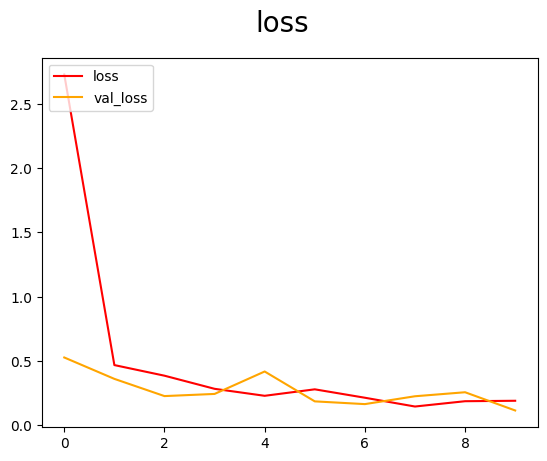

In [37]:
#Plot Performance
fig=plt.figure()
plt.plot(history.history['loss'], color='red', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

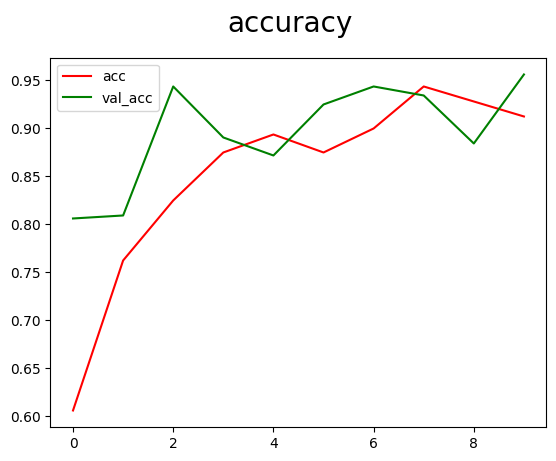

In [38]:
fig=plt.figure()
plt.plot(history.history['accuracy'], color='red', label='acc')
plt.plot(history.history['val_accuracy'], color='green', label='val_acc')
fig.suptitle('accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()



# Save model

In [ ]:
history.save('/content/drive/MyDrive/Colab Notebooks/Image/models/cnn_model_s10_e10.h5')

# Test image

In [7]:
user_image='/content/drive/MyDrive/Colab Notebooks/Image/dataset/apple/Image_47.jpg'  # apple
# user_image='/content/drive/MyDrive/Colab Notebooks/Image/dataset/banana/Image_95.jpg'  # banana

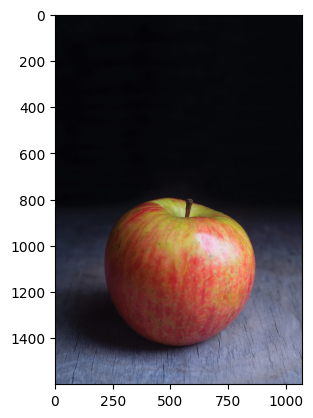

In [8]:
img_read = cv2.imread(user_image)
plt.imshow(cv2.cvtColor(img_read,cv2.COLOR_BGR2RGB))
plt.show()
# img_path

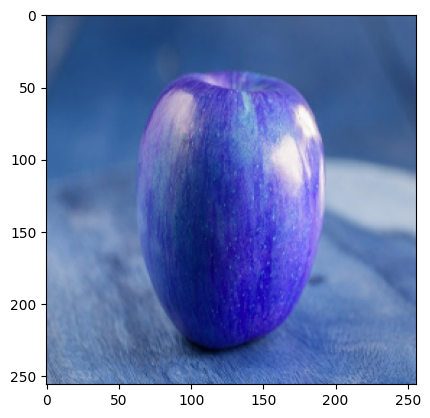

In [ ]:
img_resize = cv2.resize(img_read, (256, 256))
plt.imshow(img_resize)
plt.show()

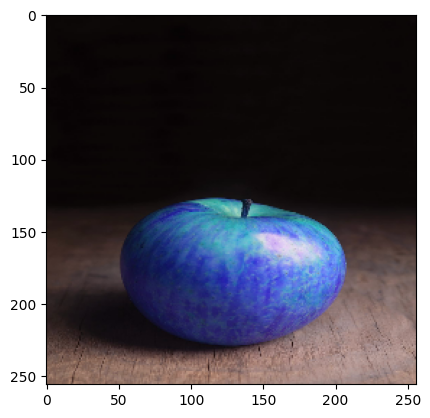

In [9]:
img_resize = tf.image.resize(img_read, (256, 256))
plt.imshow(img_resize.numpy().astype(int))
plt.show()

In [ ]:
# np_exp= np.expand_dims(img_resize,0).shape

In [10]:
img_array = np.array(img_resize) / 255.0  # normalize pixel values
img_expanded = np.expand_dims(img_array, axis=0)  # expand dimensions to match input shape


# Predict load model


In [3]:
new_model = load_model('/content/drive/MyDrive/Colab Notebooks/Image/models/cnn_model_s10_e10.h5')

In [11]:
predictions = new_model.predict(img_expanded, batch_size=10, verbose=0)
predictions

array([[0.30324903]], dtype=float32)

# Confusion matrix

In [ ]:
# # confusion matrix
# import seaborn as sns
# # Predict the values from the validation dataset
# Y_pred = model.predict(X_val)
# # Convert predictions classes to one hot vectors 
# Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# # Convert validation observations to one hot vectors
# Y_true = np.argmax(Y_val,axis = 1) 
# # compute the confusion matrix
# confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# # plot the confusion matrix
# f,ax = plt.subplots(figsize=(8, 8))
# sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()

In [ ]:
# predict on validation data
y_pred = new_model.predict(validate_data_scale)
y_pred_classes = np.argmax(y_pred, axis=1)

19/19 [==============================] - 52s 2s/step


In [ ]:
y_pred_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
# get true classes
y_true = np.concatenate([y for x, y in validate_data_scale], axis=0)
# y_true_classes = np.argmax(y_pred, axis=1)

# create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
cm

array([[302,   0],
       [301,   0]])

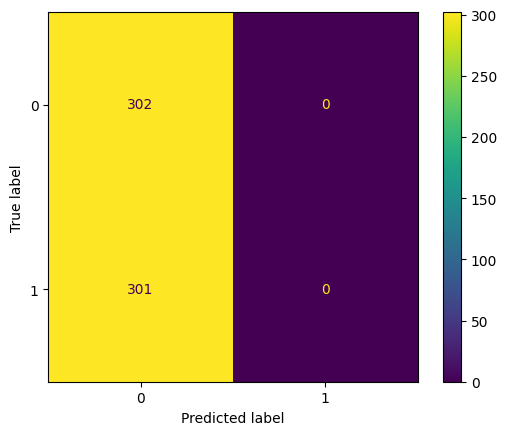

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()